In [1]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras_cv
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt

keras.utils.set_random_seed(31)

### Create the MobileNet Model

In [3]:
def depthwise_seperable_module(x, filter_size:int, depthwise_kernel:int=3, pointwise_kernel:int=1, stride:int=1):
    # depthwise block
    x = layers.DepthwiseConv2D(kernel_size=depthwise_kernel, strides=stride, padding='same',)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # pointwise block
    x = layers.Conv2D(filter_size, kernel_size=pointwise_kernel, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [4]:
def build_mobilenet(input_shape:tuple=(32, 32, 3), num_classes:int=10) -> tf.keras.Model:
    inputs = layers.Input(shape=input_shape)

    # initial convolution
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 64 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=64)

    # 128 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=128, stride=2)
    x = depthwise_seperable_module(x, filter_size=128)

    # 256 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=256, stride=2)
    x = depthwise_seperable_module(x, filter_size=256)

    # 512 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=512, stride=2)
    x = depthwise_seperable_module(x, filter_size=512)
    x = depthwise_seperable_module(x, filter_size=512)
    x = depthwise_seperable_module(x, filter_size=512)
    x = depthwise_seperable_module(x, filter_size=512)
    x = depthwise_seperable_module(x, filter_size=512)

    x = depthwise_seperable_module(x, filter_size=1024, stride=2)
    x = depthwise_seperable_module(x, filter_size=1024)

    # glob. avg. pooling and output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='mobilenet_cifar10_big')

    return model

### Prepare the Dataset

In [6]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [7]:
def prepare_dataset(dataset, shuffle:bool=True, augment:bool=False):

    rand_augment = keras_cv.layers.RandAugment(
      value_range=(0, 255), augmentations_per_image=3, magnitude=0.2
    )

    if shuffle:
      dataset = dataset.shuffle(BATCH_SIZE * 1000)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: (rand_augment(x), y),  # RandAugment can process it
            num_parallel_calls=AUTO,
        )

    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTO,
    )

    return dataset.prefetch(AUTO)

In [8]:
def fetch_and_augment_cifar10() -> tuple:
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # partition the train data to obtain a val data
    num_samples = x_train.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices, )     # shuffle to avoid bias

    x_train, y_train = x_train[indices], y_train[indices]

    val_size = int(0.1 * num_samples)

    # 45000 train and 5000 val datapoints
    x_val, y_val = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]


    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,  y_test))

    train_ds_original = prepare_dataset(train_ds)
    train_ds = prepare_dataset(train_ds, shuffle=True, augment=True)
    val_ds = prepare_dataset(val_ds)
    test_ds = prepare_dataset(test_ds, shuffle=False)

    return (train_ds, val_ds, test_ds, y_test, train_ds_original)

In [9]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = 32

train_ds, val_ds, test_ds, y_test, train_ds_original = fetch_and_augment_cifar10()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


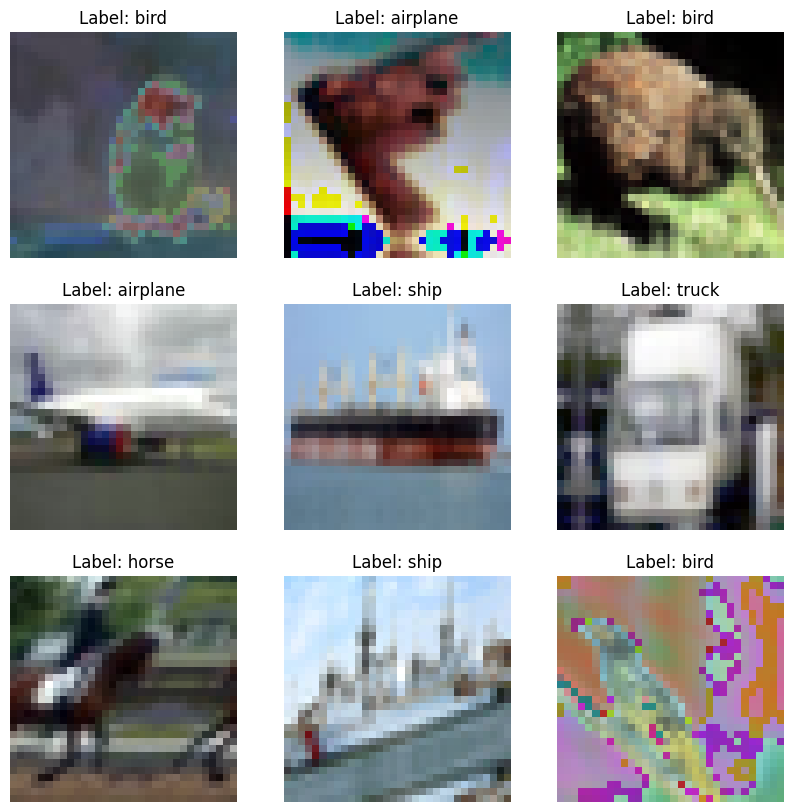

In [10]:
sample_images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {classes[int(labels[i])]}")
    plt.axis("off")

### Train the Model

In [11]:
def train_mobilenet(train_ds:tf.data.Dataset, val_ds:tf.data.Dataset) -> tuple:
    # build model
    model = build_mobilenet()

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'mobilenet_cifar10_big.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    callbacks = [
        early_stopping,
        lr_scheduler,
        model_checkpoint
    ]

    # train the model
    history = model.fit(
        train_ds,
        epochs=150,
        validation_data=val_ds,
        callbacks=callbacks
    )

    return model, history

In [12]:
model, history = train_mobilenet(train_ds, val_ds)

Epoch 1/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2001 - loss: 2.1920
Epoch 1: val_accuracy improved from -inf to 0.39200, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 50ms/step - accuracy: 0.2002 - loss: 2.1919 - val_accuracy: 0.3920 - val_loss: 1.7513 - learning_rate: 0.0010
Epoch 2/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3590 - loss: 1.7645
Epoch 2: val_accuracy improved from 0.39200 to 0.39840, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.3590 - loss: 1.7645 - val_accuracy: 0.3984 - val_loss: 1.9151 - learning_rate: 0.0010
Epoch 3/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4627 - loss: 1.5107
Epoch 3: val_accuracy improved from 0.39840 to 0.57600, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.4628 - loss: 1.5105 - val_accuracy: 0.5760 - val_loss: 1.2797 - learning_rate: 0.0010
Epoch 4/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5400 - loss: 1.3087
Epoch 4: val_accuracy improved from 0.57600 to 0.61040, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.5400 - loss: 1.3087 - val_accuracy: 0.6104 - val_loss: 1.1333 - learning_rate: 0.0010
Epoch 5/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5874 - loss: 1.1769
Epoch 5: val_accuracy improved from 0.61040 to 0.68140, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.5874 - loss: 1.1768 - val_accuracy: 0.6814 - val_loss: 0.9306 - learning_rate: 0.0010
Epoch 6/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6281 - loss: 1.0772
Epoch 6: val_accuracy improved from 0.68140 to 0.71840, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.6281 - loss: 1.0771 - val_accuracy: 0.7184 - val_loss: 0.8289 - learning_rate: 0.0010
Epoch 7/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6537 - loss: 0.9990
Epoch 7: val_accuracy improved from 0.71840 to 0.73260, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.6537 - loss: 0.9990 - val_accuracy: 0.7326 - val_loss: 0.7815 - learning_rate: 0.0010
Epoch 8/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6822 - loss: 0.9247
Epoch 8: val_accuracy improved from 0.73260 to 0.75500, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.6822 - loss: 0.9247 - val_accuracy: 0.7550 - val_loss: 0.7110 - learning_rate: 0.0010
Epoch 9/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6940 - loss: 0.8734
Epoch 9: val_accuracy improved from 0.75500 to 0.76300, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.6940 - loss: 0.8734 - val_accuracy: 0.7630 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 10/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7137 - loss: 0.8239
Epoch 10: val_accuracy improved from 0.76300 to 0.78620, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.7137 - loss: 0.8239 - val_accuracy: 0.7862 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 11/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7248 - loss: 0.7988
Epoch 11: val_accuracy improved from 0.78620 to 0.78920, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.7248 - loss: 0.7988 - val_accuracy: 0.7892 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 12/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7338 - loss: 0.7718
Epoch 12: val_accuracy improved from 0.78920 to 0.81040, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.7338 - loss: 0.7718 - val_accuracy: 0.8104 - val_loss: 0.5557 - learning_rate: 0.0010
Epoch 13/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7476 - loss: 0.7350
Epoch 13: val_accuracy did not improve from 0.81040
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.7476 - loss: 0.7350 - val_accuracy: 0.7868 - val_loss: 0.6122 - learning_rate: 0.0010
Epoch 14/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7569 - loss: 0.7049
Epoch 14: val_accuracy improved from 0.81040 to 0.83060, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.7569 - loss: 0.7049 - val_accuracy: 0.8306 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 15/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7727 - loss: 0.6618
Epoch 15: val_accuracy improved from 0.83060 to 0.83420, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.7727 - loss: 0.6619 - val_accuracy: 0.8342 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 16/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7776 - loss: 0.6518
Epoch 16: val_accuracy did not improve from 0.83420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.7776 - loss: 0.6519 - val_accuracy: 0.8202 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 17/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7852 - loss: 0.6325
Epoch 17: val_accuracy did not improve from 0.83420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.7852 - loss: 0.6325 - val_accuracy: 0.8258 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 18/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7872 - loss: 0.6111
Epoch 18: val_accuracy did not improve from 0.83420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7872 - loss: 0.6111 - val_accuracy: 0.8126 - val_loss: 0.5429 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.7978 - loss: 0.5865 - val_accuracy: 0.8400 - val_loss: 0.4672 - learning_rate: 0.0010
Epoch 21/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8060 - loss: 0.5692
Epoch 21: val_accuracy improved from 0.84000 to 0.84820, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.8060 - loss: 0.5692 - val_accuracy: 0.8482 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 22/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8094 - loss: 0.5583
Epoch 22: val_accuracy improved from 0.84820 to 0.85640, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8094 - loss: 0.5583 - val_accuracy: 0.8564 - val_loss: 0.4354 - learning_rate: 0.0010
Epoch 23/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8096 - loss: 0.5528
Epoch 23: val_accuracy did not improve from 0.85640
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8096 - loss: 0.5528 - val_accuracy: 0.8562 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 24/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8200 - loss: 0.5278
Epoch 24: val_accuracy did not improve from 0.85640
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8200 - loss: 0.5278 - val_accuracy: 0.8528 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 25/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8242 - loss: 0.5153
Epoch 25: val_accuracy improved from 0.85640 to 0.86080, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8242 - loss: 0.5153 - val_accuracy: 0.8608 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 26/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8270 - loss: 0.4972
Epoch 26: val_accuracy improved from 0.86080 to 0.86160, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8270 - loss: 0.4972 - val_accuracy: 0.8616 - val_loss: 0.4195 - learning_rate: 0.0010
Epoch 27/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8303 - loss: 0.4907
Epoch 27: val_accuracy did not improve from 0.86160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8303 - loss: 0.4907 - val_accuracy: 0.8570 - val_loss: 0.4290 - learning_rate: 0.0010
Epoch 28/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8321 - loss: 0.4874
Epoch 28: val_accuracy improved from 0.86160 to 0.86660, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8321 - loss: 0.4874 - val_accuracy: 0.8666 - val_loss: 0.4142 - learning_rate: 0.0010
Epoch 29/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8378 - loss: 0.4743
Epoch 29: val_accuracy did not improve from 0.86660
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8378 - loss: 0.4743 - val_accuracy: 0.8620 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 30/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8414 - loss: 0.4607
Epoch 30: val_accuracy did not improve from 0.86660
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8414 - loss: 0.4607 - val_accuracy: 0.8590 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 31/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8445 - loss: 0.4541
Epoch 31: val_accuracy did not improve from 0.86660
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8445 - loss: 0.4541 - val_accuracy: 0.8628 - val_loss: 0.4113 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8449 - loss: 0.4458 - val_accuracy: 0.8744 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 33/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8494 - loss: 0.4381
Epoch 33: val_accuracy did not improve from 0.87440
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.8494 - loss: 0.4382 - val_accuracy: 0.8672 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 34/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8511 - loss: 0.4298
Epoch 34: val_accuracy did not improve from 0.87440
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8511 - loss: 0.4298 - val_accuracy: 0.8588 - val_loss: 0.4243 - learning_rate: 0.0010
Epoch 35/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8524 - loss: 0.4293
Epoch 35: val_accuracy improved from 0.87440 to 0.87540, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8524 - loss: 0.4293 - val_accuracy: 0.8754 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 36/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8552 - loss: 0.4197
Epoch 36: val_accuracy did not improve from 0.87540
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8552 - loss: 0.4197 - val_accuracy: 0.8732 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 37/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8578 - loss: 0.4192
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: val_accuracy did not improve from 0.87540
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8578 - loss: 0.4192 - val_accuracy: 0.8692 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 38/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8702 - loss: 0.3731
Epoch 38: val_accuracy improved from 0.87540 to 0.88420, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8702 - loss: 0.3731 - val_accuracy: 0.8842 - val_loss: 0.3512 - learning_rate: 5.0000e-04
Epoch 39/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8820 - loss: 0.3432
Epoch 39: val_accuracy did not improve from 0.88420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8820 - loss: 0.3432 - val_accuracy: 0.8828 - val_loss: 0.3499 - learning_rate: 5.0000e-04
Epoch 40/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8892 - loss: 0.3263
Epoch 40: val_accuracy improved from 0.88420 to 0.88860, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8892 - loss: 0.3263 - val_accuracy: 0.8886 - val_loss: 0.3433 - learning_rate: 5.0000e-04
Epoch 41/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8919 - loss: 0.3192
Epoch 41: val_accuracy improved from 0.88860 to 0.89020, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8919 - loss: 0.3192 - val_accuracy: 0.8902 - val_loss: 0.3487 - learning_rate: 5.0000e-04
Epoch 42/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8884 - loss: 0.3286
Epoch 42: val_accuracy improved from 0.89020 to 0.89420, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8884 - loss: 0.3286 - val_accuracy: 0.8942 - val_loss: 0.3243 - learning_rate: 5.0000e-04
Epoch 43/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8960 - loss: 0.3063
Epoch 43: val_accuracy did not improve from 0.89420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8960 - loss: 0.3063 - val_accuracy: 0.8862 - val_loss: 0.3424 - learning_rate: 5.0000e-04
Epoch 44/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8951 - loss: 0.3106
Epoch 44: val_accuracy did not improve from 0.89420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.8951 - loss: 0.3106 - val_accuracy: 0.8886 - val_loss: 0.3478 - learning_rate: 5.0000e-04
Epoch 45/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8976 - loss: 0.2998
Epoch 45: val_accuracy did not improve from 0.89420
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8976 - loss: 0.2998 - val_accuracy: 0.8870 - val_loss: 0.3342 - l

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.9060 - loss: 0.2752 - val_accuracy: 0.8962 - val_loss: 0.3297 - learning_rate: 2.5000e-04
Epoch 49/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9115 - loss: 0.2614
Epoch 49: val_accuracy improved from 0.89620 to 0.89740, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.9115 - loss: 0.2614 - val_accuracy: 0.8974 - val_loss: 0.3259 - learning_rate: 2.5000e-04
Epoch 50/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9104 - loss: 0.2590
Epoch 50: val_accuracy improved from 0.89740 to 0.89760, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.9104 - loss: 0.2590 - val_accuracy: 0.8976 - val_loss: 0.3267 - learning_rate: 2.5000e-04
Epoch 51/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9143 - loss: 0.2551
Epoch 51: val_accuracy did not improve from 0.89760
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9143 - loss: 0.2551 - val_accuracy: 0.8962 - val_loss: 0.3309 - learning_rate: 2.5000e-04
Epoch 52/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9153 - loss: 0.2498
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 52: val_accuracy did not improve from 0.89760
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9153 - loss: 0.2498 - val_accuracy: 0.8956 - val_loss: 0.3331 - learning_rate: 2.5000e-04
Epoch 53/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9210 - loss: 0.2306
Epoch 53: val_accuracy improved from 0.89760 to 0.89900, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.9210 - loss: 0.2306 - val_accuracy: 0.8990 - val_loss: 0.3210 - learning_rate: 1.2500e-04
Epoch 54/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9212 - loss: 0.2309
Epoch 54: val_accuracy improved from 0.89900 to 0.90160, saving model to mobilenet_cifar10_big.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.9212 - loss: 0.2310 - val_accuracy: 0.9016 - val_loss: 0.3173 - learning_rate: 1.2500e-04
Epoch 55/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9228 - loss: 0.2287
Epoch 55: val_accuracy did not improve from 0.90160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.9228 - loss: 0.2287 - val_accuracy: 0.8994 - val_loss: 0.3161 - learning_rate: 1.2500e-04
Epoch 56/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9240 - loss: 0.2235
Epoch 56: val_accuracy did not improve from 0.90160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.9240 - loss: 0.2235 - val_accuracy: 0.9010 - val_loss: 0.3207 - learning_rate: 1.2500e-04
Epoch 57/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9253 - loss: 0.2216
Epoch 57: val_accuracy did not improve from 0.90160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9253 - loss: 0.2216 - val_accuracy: 0.8988 - val_loss: 0.3181 - l

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.9275 - loss: 0.2188 - val_accuracy: 0.9032 - val_loss: 0.3175 - learning_rate: 1.2500e-04
Epoch 60/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9280 - loss: 0.2199
Epoch 60: val_accuracy did not improve from 0.90320
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9280 - loss: 0.2199 - val_accuracy: 0.8996 - val_loss: 0.3176 - learning_rate: 1.2500e-04
Epoch 61/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9247 - loss: 0.2215
Epoch 61: val_accuracy did not improve from 0.90320
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9247 - loss: 0.2215 - val_accuracy: 0.9012 - val_loss: 0.3180 - learning_rate: 1.2500e-04
Epoch 62/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9299 - loss: 0.2066
Epoch 62: val_accuracy did not improve from 0.90320
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.9299 - loss: 0.2066 - val_accuracy: 0.8988 - val_loss: 0.3242 - l

### Evaluate the Model

In [13]:
model.summary()

Model: "mobilenet_cifar10_big"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_13                  │ (None, 32, 32, 32)          │             320 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_14                  │ (None, 16, 16, 64)          │             640 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 128)         │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_15                  │ (None, 16, 16, 128)         │           1,280 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,706,400 (37.03 MB)

 Trainable params: 3,228,170 (12.31 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 6,456,342 (24.63 MB)

In [14]:
_, acc = model.evaluate(train_ds_original)
print("Original Training Accuracy = ", (acc * 100.0), "%")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9989 - loss: 0.0118
Original Training Accuracy =  99.87555742263794 %


In [15]:
_, acc = model.evaluate(val_ds)
print("Validation Accuracy = ", (acc * 100.0), "%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8971 - loss: 0.3060
Validation Accuracy =  89.9399995803833 %


In [16]:
_, acc = model.evaluate(test_ds)
print("Test Accuracy = ", (acc * 100.0), "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9010 - loss: 0.3324
Test Accuracy =  90.10000228881836 %


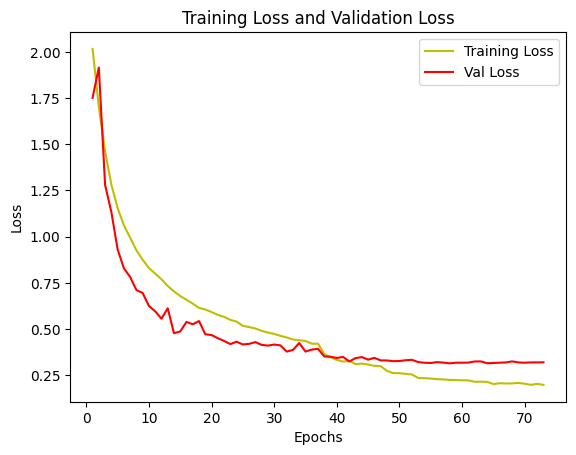

In [17]:
# plot the loss curve
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]
epochs = range(1, len(loss_curve) + 1)
plt.plot(epochs, loss_curve, 'y', label="Training Loss")
plt.plot(epochs, val_loss_curve, 'r', label="Val Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

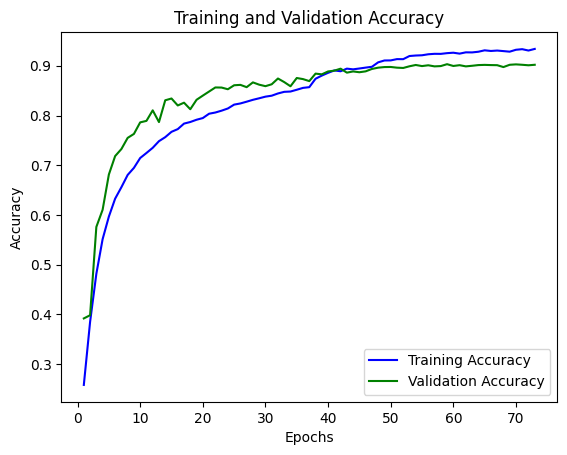

In [18]:
# plot the accuracy curve
acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]
epochs = range(1, len(acc_curve) + 1)
plt.plot(epochs, acc_curve, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_curve, 'g', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.96      0.95      0.96      1000
           2       0.89      0.87      0.88      1000
           3       0.80      0.76      0.78      1000
           4       0.89      0.90      0.89      1000
           5       0.84      0.81      0.83      1000
           6       0.92      0.94      0.93      1000
           7       0.93      0.94      0.93      1000
           8       0.93      0.95      0.94      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



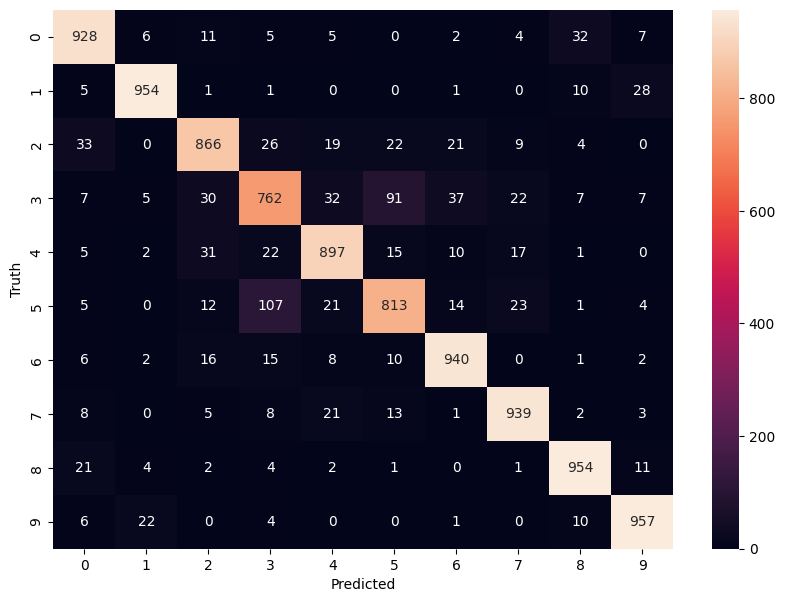

In [20]:
cm = tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Report on MobileNetBig for CIFAR-10

#### Overview
Following the success of the **1M-parameter MobileNet**, I experimented with a **larger MobileNet** model containing **3.2 million parameters** to analyze the impact of increased capacity on performance.  

#### Model Comparison

Below is an updated table comparing all trained models, now including the **larger MobileNet**:

| Model | Training Accuracy (%) | Test Accuracy (%) | Parameters (M) | Epochs | Training-Test Gap (%) |
|-------|----------------------|-------------------|----------------|---------|---------------------|
| ResNet | 99.93 | 93.19 | 21.2 | 53* | 6.74 |
| MobileNet | 99.94 | 90.75 | 1.0 | 65** | 9.19 |
| **MobileNetBig** | **99.87** | **90.10** | **3.2** | **58\*\*\*** | **9.77** |
| Inception + BatchNorm | 99.31 | 89.87 | 1.6 | 50 | 9.44 |
| VGG + BatchNorm | 95.29 | 86.58 | 33.6 | 50 | 8.71 |
| AlexNet | 81.97 | 77.53 | 3.2 | 50 | 4.44 |

*ResNet was initially configured for 150 epochs but stopped at 68, with best performance at epoch 53.
**MobileNet was initially configured for 150 epochs but stopped at 80, with best performance at epoch 65.
***MobileNetBig was initially configured for 150 epochs but stopped at 73, with best performance at epoch 58.

#### Analysis and Comparison

##### 1. **Impact of Increasing Parameters**
- **Training Accuracy:**  
  - The **smaller MobileNet (1.0M) achieved the highest training accuracy (99.94%)**, slightly higher than the larger MobileNet (99.87%).  
  - This suggests that **increasing parameters did not necessarily improve training accuracy** and might have introduced slightly more regularization effects.
  
- **Test Accuracy:**  
  - The **smaller MobileNet (1.0M) also achieved a higher test accuracy (90.75%)** than the larger one (90.10%).
  - This indicates that increasing model size did **not** significantly improve generalization and might have led to mild overfitting.

##### 2. **Efficiency vs Performance Tradeoff**
- The **smaller MobileNet (1M)** remains **more efficient** than the **larger MobileNet (3.2M)**, achieving **better accuracy with fewer parameters**.
- The larger model **tripled the parameter count but failed to surpass the smaller version**, making it a **less efficient choice**.

##### 3. **Comparison with Other Models**
- Both MobileNet variants **outperform Inception (89.87%) and VGG (86.58%)** while being significantly smaller than VGG.
- Neither MobileNet variant could surpass **ResNet (93.19%)**, but they still provide a strong accuracy-to-parameter ratio.

#### Conclusion & Key Takeaways
1. **The smaller MobileNet (1M) is the best balance of accuracy and efficiency.**  
   - It achieves the highest test accuracy (90.75%) while using the fewest parameters (1.0M).
   - It generalizes better than the larger MobileNet (3.2M) and avoids unnecessary overfitting.

2. **Scaling up MobileNet did not improve performance.**  
   - The 3.2M model overfits slightly more and fails to surpass the smaller MobileNet.
   - Increasing parameters alone is not always beneficial—architectural changes or better regularization may be needed for improvements.

3. **MobileNet remains a strong alternative to larger models.**  
   - It achieves competitive performance despite being significantly smaller than ResNet, VGG, and Inception.
   - Future improvements could involve better regularization, fine-tuning, or architectural optimizations rather than just increasing size.

Overall, the smaller MobileNet (1M) is the preferred model for CIFAR-10 in terms of both performance and efficiency.